In [35]:
# libraries required for feature extraction using MobileNet version:1

In [47]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [48]:
#base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/X.npy'' # Data Path 
base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/asm_images/'
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [49]:
# classes in malimg data
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [50]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


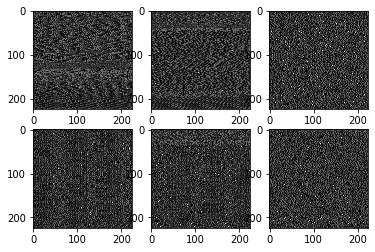

In [26]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [51]:
asm_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV3_Small_feat_asm_microsoft_1024.npy')
bytes_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV3_Small_feat_bytes_microsoft_1024.npy')

In [52]:
bytes_features.shape, asm_features.shape

((10868, 1024), (10868, 1024))

In [53]:
X = []
for i in range(len(asm_features)):
    x = list(np.hstack((asm_features[i], bytes_features[i])))
    X.append(x)

In [54]:
X =  np.array(X)
X.shape

(10868, 2048)

## Classification using SVM(Support Vector Meachine/Classifier)

In [55]:
# libraries required for Naive_Bayes classification

In [56]:
import pandas as pd
import disarray as da
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef, roc_curve, auc

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [60]:
print("X_Train:", X_train.shape)
print("Y_Train:", y_train.shape)
print("X_Test:", X_test.shape)
print("Y_Test:", y_test.shape)

X_Train: (8585, 2048)
Y_Train: (8585,)
X_Test: (2283, 2048)
Y_Test: (2283,)


In [61]:
svc = SVC(kernel = 'linear',C = 0.1)

In [62]:
%%time
svc.fit(X_train,y_train)

CPU times: user 40 s, sys: 0 ns, total: 40 s
Wall time: 40 s


SVC(C=0.1, kernel='linear')

In [63]:
print("Testing Accuracy:", round((svc.score(X_test, y_test) * 100), 2))

Testing Accuracy: 85.28


In [64]:
%%time
y_pred = svc.predict(X_test)

CPU times: user 13.6 s, sys: 0 ns, total: 13.6 s
Wall time: 13.6 s


In [65]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

85 85 85
CPU times: user 5.63 ms, sys: 0 ns, total: 5.63 ms
Wall time: 4.6 ms


In [66]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.72      0.81      0.76       195
         1.0       0.75      1.00      0.86        61
         2.0       0.98      0.95      0.97       642
         3.0       0.93      0.71      0.80       670
         4.0       0.87      0.92      0.89       231
         5.0       0.90      0.92      0.91       326
         6.0       0.00      0.00      0.00         0
         7.0       0.59      0.88      0.71       104
         8.0       0.36      0.74      0.48        54

    accuracy                           0.85      2283
   macro avg       0.68      0.77      0.71      2283
weighted avg       0.88      0.85      0.86      2283



In [67]:
# GridSearchCV

In [68]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 1, 10, 100], 
              'kernel': ['linear', 'rbf']
             }

In [69]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')

CPU times: user 156 µs, sys: 0 ns, total: 156 µs
Wall time: 165 µs


In [70]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 4h 6min 36s, sys: 32.2 s, total: 4h 7min 9s
Wall time: 4h 11min 44s


GridSearchCV(cv=5, estimator=SVC(C=0.1, kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [71]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [72]:
print("Accuracy on testing set: {:.3f}".format(grid_search.score(X_test, y_test)))

Accuracy on testing set: 0.931


In [26]:
y_pred = grid_search.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
                 precision    recall  f1-score   support

         Gatak       0.88      0.91      0.89       228
  Kelihos_ver1       0.98      0.98      0.98        82
  Kelihos_ver3       0.98      0.98      0.98       636
      Lollipop       0.94      0.94      0.94       509
Obfuscator.ACY       0.96      0.91      0.93       246
        Ramnit       0.93      0.97      0.95       316
         Simda       0.75      0.33      0.46         9
        Tracur       0.89      0.88      0.88       152
         Vundo       0.88      0.85      0.86       105

      accuracy                           0.94      2283
     macro avg       0.91      0.86      0.88      2283
  weighted avg       0.94      0.94      0.94      2283



In [4]:
data = [
    {"Class": "Gatak", "Precision": 0.88, "Recall": 0.91, "F1-Score": 0.89, "Support": 228},
    {"Class": "Kelihos_ver1", "Precision": 0.98, "Recall": 0.98, "F1-Score": 0.98, "Support": 82},
    {"Class": "Kelihos_ver3", "Precision": 0.98, "Recall": 0.98, "F1-Score": 0.98, "Support": 636},
    {"Class": "Lollipop", "Precision": 0.94, "Recall": 0.94, "F1-Score": 0.94, "Support": 509},
    {"Class": "Obfuscator.ACY", "Precision": 0.96, "Recall": 0.91, "F1-Score": 0.93, "Support": 246},
    {"Class": "Ramnit", "Precision": 0.93, "Recall": 0.97, "F1-Score": 0.95, "Support": 316},
    {"Class": "Simda", "Precision": 0.75, "Recall": 0.33, "F1-Score": 0.46, "Support": 9},
    {"Class": "Tracur", "Precision": 0.89, "Recall": 0.88, "F1-Score": 0.88, "Support": 152},
    {"Class": "Vundo", "Precision": 0.88, "Recall": 0.85, "F1-Score": 0.86, "Support": 105}
]
recall_values = [item["F1-Score"] for item in data]
for value in recall_values:
    print(value)

0.89
0.98
0.98
0.94
0.93
0.95
0.46
0.88
0.86


In [27]:
list_fams = sorted(label_dict.keys())

In [28]:
classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/plots/MobileNetV3_Small_SVM_asm.csv')

Plotting the confusion matrix


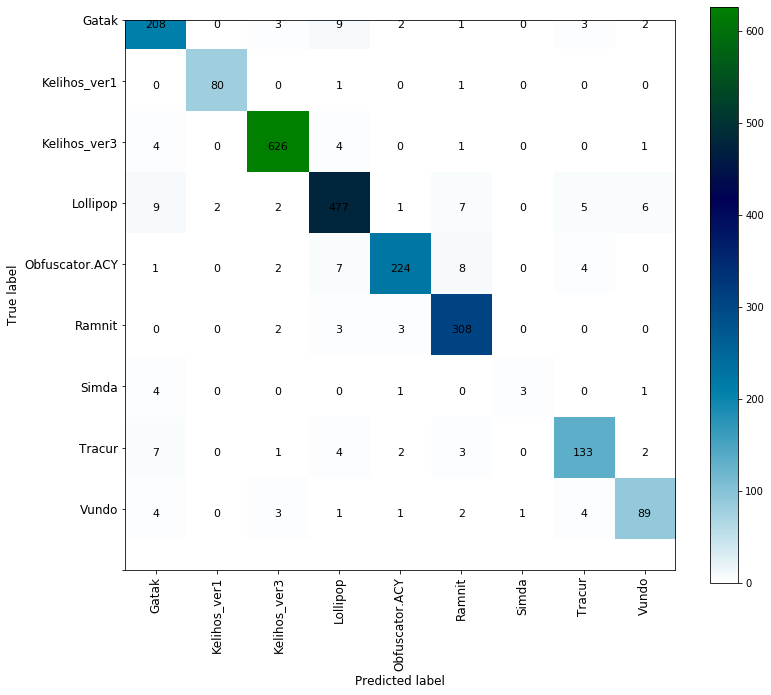

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=11)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.tight_layout()
plt.colorbar()
plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/plots/MobileNetV3_Small_SVM_asm.eps', bbox_inches='tight')
plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/plots/MobileNetV3_Small_SVM_asm.png', bbox_inches='tight')

plt.show()

In [30]:
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm)

In [31]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [32]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [33]:
FP, FN, TP, TN

(array([29,  2, 13, 29, 10, 23,  1, 16, 12]),
 array([20,  2, 10, 32, 22,  8,  6, 19, 16]),
 array([208,  80, 626, 477, 224, 308,   3, 133,  89]),
 array([2026, 2199, 1634, 1745, 2027, 1944, 2273, 2115, 2166]))

In [34]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.00977517, 0.00090868, 0.00608273, 0.01800788, 0.01073694,
       0.00409836, 0.00263273, 0.00890347, 0.00733272])

In [35]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [36]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,0.912281,0.985888,0.014112,0.087719,0.122363,0.009775
Kelihos_ver1,0.975610,0.999091,0.000909,0.024390,0.024390,0.000909
Kelihos_ver3,0.984277,0.992107,0.007893,0.015723,0.020344,0.006083
Lollipop,0.937132,0.983653,0.016347,0.062868,0.057312,0.018008
Obfuscator.ACY,0.910569,0.995091,0.004909,0.089431,0.042735,0.010737
Ramnit,0.974684,0.988307,0.011693,0.025316,0.069486,0.004098
Simda,0.333333,0.999560,0.000440,0.666667,0.250000,0.002633
Tracur,0.875000,0.992492,0.007508,0.125000,0.107383,0.008903
Vundo,0.847619,0.994490,0.005510,0.152381,0.118812,0.007333


In [37]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 86.1167
Average of true_negative_rate --> 99.2298
Average of false_positive_rate --> 0.7702
Average of false_negative_rate --> 13.8833
Average of false_discovery_rate --> 9.0314
Average of false_omission_rate --> 0.7609


In [38]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_test, y_pred), 2))

MCC Score: 0.93


In [39]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.9408672798948752
micro_recall : 0.9408672798948752
micro_f1_score : 0.9408672798948752


In [40]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.9096860518769257
macro_recall : 0.8611670943341401
macro_f1_score : 0.8763169580542303


In [41]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [42]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [43]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

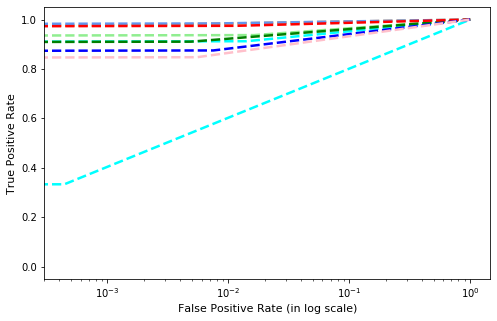

In [44]:
# Compute macro-average ROC curve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/plots/MobileNetV3_Small_SVM_asm.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/plots/MobileNetV3_Small_SVM_asm.png", bbox_inches='tight')

plt.show()